In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from bank_schedule.data import Data
from bank_schedule.helpers  import calc_cartesian_coords
from bank_schedule import forecast
from bank_schedule.constants import RAW_DATA_FOLDER

In [2]:
def add_last_cash_collection_date(residuals: pd.DataFrame,
                                  income: pd.DataFrame):
    """Считает ориентировочную дату последней инкассации
    на момент 2022-08-31 исходя из средней заполняемости банкомата в день

    Args:
        residuals (pd.DataFrame): _description_
        income (pd.DataFrame): _description_
    """
    avg_day_income = income.groupby('TID')['money_in'].mean()
    residuals = residuals.set_index('TID').loc[avg_day_income.index, :]
    residuals_series = residuals['money']

    days_from_last_collection = np.ceil(residuals_series / avg_day_income).astype(int)

    residuals['last_collection_date'] = residuals['date'] - pd.to_timedelta(days_from_last_collection,
                                                                            unit='D')
    return residuals.reset_index()


def get_income_on_horizon(today_date: str,
                          forecaset_model: object,
                          horizon: int=3) -> pd.DataFrame:
    """Получает суммарный приход денег в банкоматах на заданном горизонте

    Args:
        today_date (str): _description_
        forecaset_model (object): _description_
        horizon (int, optional): _description_. Defaults to 3.
    """
    predictions = forecaset_model.predict(today_date, horizon)
    return predictions.groupby('TID')['money_in'].sum().reset_index()


def get_residuals_on_horizon(today_date: str,
                             today_residuals: pd.DataFrame,
                             forecaset_model: object,
                             horizon: int=3) -> pd.DataFrame:
    """Возвращает количество денег в банкоматах через horizon дней

    Args:
        today_date (str): _description_
        today_cash (pd.DataFrame): _description_
        horizon (int, optional): _description_. Defaults to 3.
    """
    money = today_residuals.set_index('TID')['money']

    horizon_income = get_income_on_horizon(today_date, forecaset_model, horizon)
    horizon_income = horizon_income.set_index('TID').loc[money.index, 'money_in']

    money += horizon_income
    money.index = today_residuals.index

    horizon_residuals = today_residuals.copy()
    horizon_residuals['date'] = pd.to_datetime(today_date) + pd.Timedelta(days=horizon)
    horizon_residuals['money'] = money.copy()

    return horizon_residuals


def add_overflow_date(residuals: pd.DataFrame,
                      forecast_model: object,
                      overflow_thresh: int=10**6,
                      horizon: int=1,
                      max_horizon: int=100):
    """Проставляет дату переполнения

    Args:
        residuals (pd.DataFrame): текущие остатки в банкоматах
        forecast_model (object): модель прогноза
        overflow_thresh (int, optional): порог переполнения. Defaults to 10**6.
        horizon (int, optional): шаг расчета в днях. Defaults to 1.
        max_horizon (int, optional): на сколько максимум дней смотреть вперед. Defaults to 100.

    Raises:
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    residuals = residuals.copy()
    if residuals['date'].unique().shape[0] != 1:
        raise ValueError('Уникальных сегодняшних дат в residuals > 1')

    today = residuals['date'].unique()[0]
    new_residuals = residuals[['TID', 'money', 'date']].copy()

    counter = 0

    while residuals['overflow_date'].isnull().any() and counter < max_horizon:
        new_residuals = get_residuals_on_horizon(today, new_residuals, forecast_model, horizon=horizon)
        overflow_cond = new_residuals['money'] > overflow_thresh
        overflow_cond &= residuals['overflow_date'].isna()

        today = today + pd.Timedelta(days=horizon)
        residuals.loc[overflow_cond, 'overflow_date'] = today
        counter += 1

    residuals['overflow_date'] = residuals['overflow_date'].fillna(today)

    return residuals


def add_deadline_soon_flag(residuals: pd.DataFrame,
                           overflow_thresh: int=3,
                           cash_collection_thresh: int=3,
                           max_cash_collection_gap: int=14):
    """Добавляет флаг 'скоро дедлайн'

    Args:
        residuals (pd.DataFrame): _description_
        deadline_thresh (int, optional): _description_. Defaults to 3.
    """
    days_from_last_collection_max = max_cash_collection_gap - cash_collection_thresh

    # до переполнеия меньше deadline_thresh дней
    overflow_cond = residuals['overflow_date'] - residuals['date'] < pd.Timedelta(days=overflow_thresh)

    # со дня последней инкассации прошло не менее, чем max_cash_collection_gap - cash_collection_thresh
    cash_collection_cond = residuals['date'] - residuals['last_collection_date'] \
        >= pd.Timedelta(days_from_last_collection_max)

    residuals['deadline_soon'] = overflow_cond & cash_collection_cond
    return residuals

In [3]:
loader = Data(RAW_DATA_FOLDER)
dists = loader.get_distance_matrix()
geo = loader.get_geo_TIDS()
geo.set_index('TID', inplace=True)
income = loader.get_money_in()
residuals = loader.get_money_start()
residuals['date'] = pd.to_datetime('2022-08-31')
residuals = add_last_cash_collection_date(residuals, income)
residuals['overflow_date'] = pd.NaT

In [4]:
hist_mdl = forecast.ForecastHistorical()
lgbm_mdl = forecast.IncomeForecastLGBM()

In [5]:
new_resids_hist = add_deadline_soon_flag(add_overflow_date(residuals, hist_mdl))
new_resids_lgbm = add_deadline_soon_flag(add_overflow_date(residuals, lgbm_mdl))

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:348: UserWarning: Дата 2022-12-01 00:00:00 не найдена в исторических данных, прогнозируем средним по TID
  warn(f'Дата {next_date} не найдена в исторических данных, прогнозируем средним по TID')
/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:348: UserWarning: Дата 2022-12-02 00:00:00 не найдена в исторических данных, прогнозируем средним по TID
  warn(f'Дата {next_date} не найдена в исторических данных, прогнозируем средним по TID')
/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:348: UserWarning: Дата 2022-12-03 00:00:00 не найдена в исторических данных, прогнозируем средним по TID
  warn(f'Дата {next_date} не найдена в исторических данных, прогнозируем средним по TID')
/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:348: UserWarning: Дата 2022-12-04 00:00:00 не найдена в исторических данных, прогнозируем средним по TID
  warn(f'Д

In [6]:
display(new_resids_hist[new_resids_hist['deadline_soon']])

,TID,money,date,last_collection_date,overflow_date,deadline_soon
7,406504,819000,2022-08-31,2022-08-28,2022-09-01,True
8,406509,892000,2022-08-31,2022-08-24,2022-09-01,True
13,406597,900000,2022-08-31,2022-08-19,2022-09-01,True
14,407002,709000,2022-08-31,2022-08-24,2022-09-02,True
15,407025,733000,2022-08-31,2022-08-27,2022-09-01,True
16,605329,740000,2022-08-31,2022-08-29,2022-09-01,True
245,608039,1132000,2022-08-31,2022-08-21,2022-09-01,True
264,608096,612000,2022-08-31,2022-08-28,2022-09-02,True
307,609492,851000,2022-08-31,2022-08-23,2022-09-02,True
385,619507,804000,2022-08-31,2022-08-25,2022-09-02,True


In [7]:
display(new_resids_lgbm[new_resids_lgbm['deadline_soon']])

,TID,money,date,last_collection_date,overflow_date,deadline_soon
7,406504,819000,2022-08-31,2022-08-28,2022-09-01,True
8,406509,892000,2022-08-31,2022-08-24,2022-09-01,True
13,406597,900000,2022-08-31,2022-08-19,2022-09-02,True
15,407025,733000,2022-08-31,2022-08-27,2022-09-02,True
16,605329,740000,2022-08-31,2022-08-29,2022-09-01,True
73,606127,765000,2022-08-31,2022-08-24,2022-09-02,True
245,608039,1132000,2022-08-31,2022-08-21,2022-09-01,True
264,608096,612000,2022-08-31,2022-08-28,2022-09-02,True
307,609492,851000,2022-08-31,2022-08-23,2022-09-02,True
385,619507,804000,2022-08-31,2022-08-25,2022-09-02,True


In [8]:
start = pd.to_datetime('2022-08-31')
end = pd.to_datetime('2022-10-30')

today = start
results_list = []
new_resids = residuals.copy()

while today <= end:
    result = add_deadline_soon_flag(new_resids)
    results_list.append(result.copy())
    new_resids = result.copy()

    # инкассируем банкоматы, близкие к дедлайну, сбрасываем деньги,
    # время инкассации и переполнения
    new_resids.loc[new_resids['deadline_soon'], 'money'] = 0
    new_resids.loc[new_resids['deadline_soon'], 'last_collection_date'] = today
    new_resids.loc[new_resids['deadline_soon'], 'overflow_date'] = pd.NaT

    # на следующий день банкоматы пополняются
    new_resids = get_residuals_on_horizon(today, new_resids, hist_mdl, horizon=1)
    new_resids = add_overflow_date(new_resids, lgbm_mdl)
    today += pd.Timedelta(days=1)

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:237: UserWarning: Дата 2022-12-01 00:00:00 не найдена в данных, прогнозируем средним по TID
  warn(f'Дата {today_date} не найдена в данных, прогнозируем средним по TID')
/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:237: UserWarning: Дата 2022-12-01 00:00:00 не найдена в данных, прогнозируем средним по TID
  warn(f'Дата {today_date} не найдена в данных, прогнозируем средним по TID')
/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:237: UserWarning: Дата 2022-12-02 00:00:00 не найдена в данных, прогнозируем средним по TID
  warn(f'Дата {today_date} не найдена в данных, прогнозируем средним по TID')
/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:237: UserWarning: Дата 2022-12-03 00:00:00 не найдена в данных, прогнозируем средним по TID
  warn(f'Дата {today_date} не найдена в данных, прогнозируем средним по TID')
/Users/affernus/PROJ

In [14]:
deadline_soon_counts = []
dates = []
for res in  results_list:
    deadline_soon_counts.append(res['deadline_soon'].sum())
    dates.append(res['date'].iloc[0])

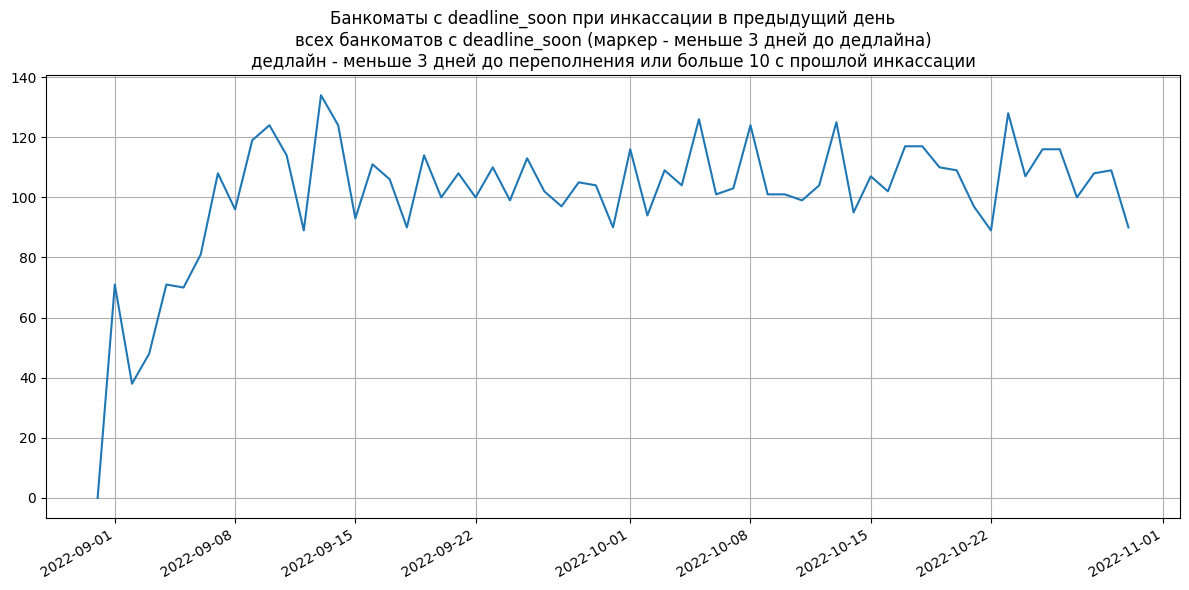

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(data=deadline_soon_counts, index=dates))
plt.title('Банкоматы с deadline_soon при инкассации в предыдущий день\n'
          'всех банкоматов с deadline_soon (маркер - меньше 3 дней до дедлайна)\n'
          'дедлайн - меньше 3 дней до переполнения или больше 10 с прошлой инкассации')
fig.autofmt_xdate()
plt.tight_layout()
plt.grid()
plt.show()